Interested to investigate whether the CLIP scores we used to sort the initial stimuli into bins match the scores assigned at the very end of the process, as there may be small differences in implementation between the initial and final CLIP implementations.

All stimuli

In [1]:
import pandas as pd

stimuli_df = pd.read_pickle("../stimuli/all_stimuli_with_initial_clip_score.pickle").sort_values(by=['filename'])

new_clip_stimuli_scores = pd.read_pickle("../xai_maps/xai_output/CLIP_stimuli_output_scores.pickle")

new_clip_valse_scores = pd.read_pickle("../xai_maps/xai_output/CLIP_all_of_valse_output_scores.pickle")

In [2]:
stimuli_df.head(2)

,index,Unnamed: 0,Selection,img_path,caption,foil,linguistic_phenomena,Approval,Notes,clip_pred_caption,clip_pred_foil,clip_pred_diff,performance_group,"% can't tell (google form, existence only)","% can tell (google form, existence only)","% unsure (google form, existence only)",Caption edited,Foil edited,filename
88,22,0,First set (Jan 16),../VALSE_data/images/coco2017/000000001584.jpg,"The red, double decker bus is driving past oth...","The red, double decker bus is driving towards ...",relations,Approve,NaN,30.269650,30.401030,-0.131380,low_perf,NaN,NaN,NaN,False,False,000000001584.jpg
22,22,1,First set (Jan 16),../VALSE_data/images/coco2017/000000005529.jpg,A person on skis is skiing down a snowy hill.,A person on skis is skiing up a snowy hill.,relations,Approve,NaN,29.881712,29.797729,0.083982,medium_perf,NaN,NaN,NaN,False,False,000000005529.jpg


### First, confirm that VALSE and stimuli alone has the exact same output values -- this is unrelated to the main task of this notebook

In [3]:
new_clip_valse_scores_filtered = new_clip_valse_scores[new_clip_valse_scores['img_path'].isin(list(new_clip_stimuli_scores['img_path']))]

In [4]:
new_clip_valse_scores_filtered.sort_values(by=['img_path']).head(3)

,img_path,caption,foil,linguistic_phenomena,model_pred_caption,model_pred_foil,model_pred_diff
503,../../VALSE_data/images/coco2017/000000001584.jpg,"The red, double decker bus is driving past oth...","The red, double decker bus is driving towards ...",relations,30.269650,30.401030,-0.131380
453,../../VALSE_data/images/coco2017/000000005529.jpg,A person on skis is skiing down a snowy hill.,A person on skis is skiing up a snowy hill.,relations,29.881712,29.797729,0.083982
220,../../VALSE_data/images/coco2017/000000021903.jpg,A man reaches out to give the elephant something.,A man reaches inside to give the elephant some...,relations,31.920687,31.598303,0.322384


In [5]:
new_clip_valse_scores_filtered.sort_values(by=['img_path']).head(3)

,img_path,caption,foil,linguistic_phenomena,model_pred_caption,model_pred_foil,model_pred_diff
503,../../VALSE_data/images/coco2017/000000001584.jpg,"The red, double decker bus is driving past oth...","The red, double decker bus is driving towards ...",relations,30.269650,30.401030,-0.131380
453,../../VALSE_data/images/coco2017/000000005529.jpg,A person on skis is skiing down a snowy hill.,A person on skis is skiing up a snowy hill.,relations,29.881712,29.797729,0.083982
220,../../VALSE_data/images/coco2017/000000021903.jpg,A man reaches out to give the elephant something.,A man reaches inside to give the elephant some...,relations,31.920687,31.598303,0.322384


Confirmed. Now the harder part.

### See relationship between old and new clip pred difference

In [6]:
new_clip_stimuli_scores['filename'] = [os.path.basename(path) for path in new_clip_stimuli_scores['img_path']]
new_clip_stimuli_scores = new_clip_stimuli_scores.sort_values(by=['filename'])
new_clip_stimuli_scores.filename

NameError: name 'os' is not defined

Check the filenames are exactly in the same order, should be 1.0

In [ ]:
import numpy as np
np.mean(stimuli_df.filename == new_clip_stimuli_scores.filename) # they are all equal

1.0

Add the old scores to the new scores dataframe

In [ ]:
new_clip_stimuli_scores['old_clip_caption'] = stimuli_df['clip_pred_caption']
new_clip_stimuli_scores['old_clip_foil'] = stimuli_df['clip_pred_foil']
new_clip_stimuli_scores['old_clip_diff'] = stimuli_df['clip_pred_diff']

Graph

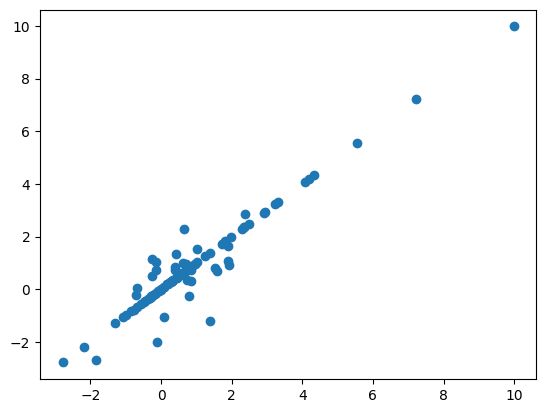

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(new_clip_stimuli_scores['old_clip_diff'], new_clip_stimuli_scores['model_pred_diff'])


### This is good news. Now let's see if our dataset is still overall balanced

In [ ]:
thresholds = new_clip_valse_scores.groupby('linguistic_phenomena')['model_pred_diff'].quantile([0.33, 0.66])
thresholds = thresholds
thresholds

linguistic_phenomena      
actions               0.33    0.330514
                      0.66    1.850014
existence             0.33    0.069525
                      0.66    0.924227
relations             0.33   -0.011719
                      0.66    0.497886
Name: model_pred_diff, dtype: float64

In [ ]:
def categorize_performance(row, low_percentile = 0.33, high_percentile = 0.66):
    """For a row from the dataframe, assign low/medium/high performance 
    based on comparing the clip_pred_diff to the thresholds for that linguistic phenomena"""

    if row['model_pred_diff'] <= thresholds[row['linguistic_phenomena']][low_percentile]:
        return "low_perf"
    elif row['model_pred_diff']<=thresholds[row['linguistic_phenomena']][high_percentile]:
        return "medium_perf"
    else:
        return "high_perf"
    
new_clip_stimuli_scores['performance_group'] = [categorize_performance(row) for _, row in new_clip_stimuli_scores.iterrows()]


In [ ]:
new_clip_stimuli_scores.groupby(['linguistic_phenomena', 'performance_group']).size()

linguistic_phenomena  performance_group
actions               high_perf            12
                      low_perf             12
                      medium_perf           9
existence             high_perf            11
                      low_perf              9
                      medium_perf          13
relations             high_perf            12
                      low_perf             12
                      medium_perf           9
dtype: int64